In [1]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

In [27]:
PROJECT_PATH = Path.cwd().resolve()
DATA_PATH = PROJECT_PATH.parent / 'aust_renewal/data/'

In [29]:
target_data = pd.read_csv(DATA_PATH / "WHO-COVID-19-global-data_21_8_24.csv")

In [82]:
df_int = target_data.loc[target_data['Country'] == 'Australia']

df_int ['Date_reported'] = pd.to_datetime(df_int['Date_reported'], format="%d/%m/%Y")
df_int = df_int.set_index('Date_reported')

# drop uneeded columns
df_interp = df_int.drop(['Country','Country_code','WHO_region', 'Cumulative_cases','New_deaths','Cumulative_deaths'], axis=1)

df = df_interp.resample('W-SUN').interpolate(method='linear')

df['New_cases'] = df['New_cases'].fillna(0)

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_6092\224007255.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



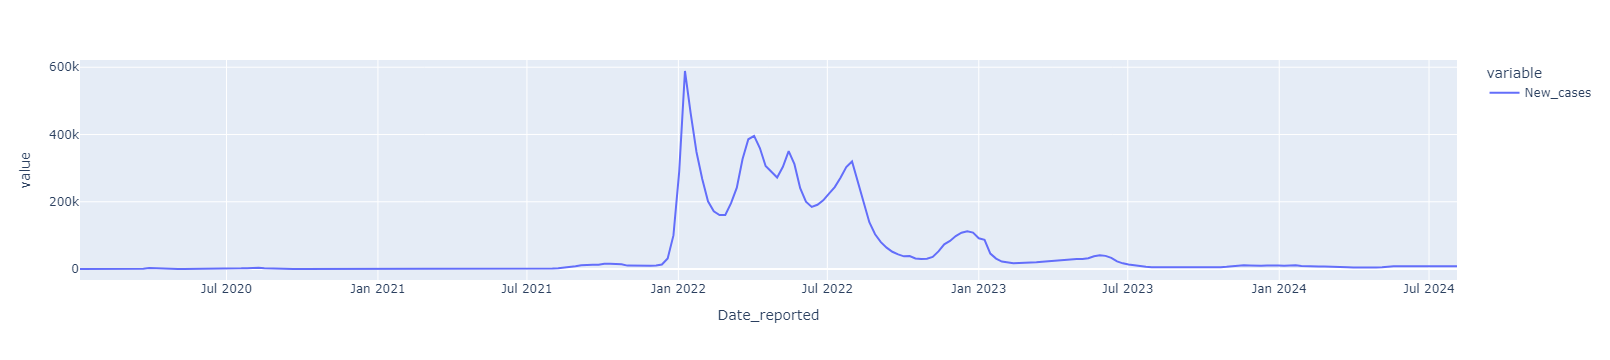

In [83]:
df.plot()
# missing week of data on 3rd July 2022

In [84]:
df = df.iloc[:,0]

In [124]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
data = df
pop = 26e6
analysis_start = datetime(2021, 12, 1)
analysis_end = datetime(2022, 10, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = data.loc[analysis_start: analysis_end]
init_data = data.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [125]:
# Define model and fitter
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [126]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(16, 40),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3, 0.5, low=1.0),
}

In [127]:
# Define and run calibration
calib = StandardCalib(renew_model, priors, select_data, indicator='weekly_sum')
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=4, num_samples=1000, num_warmup=200)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [128]:
# Grab sample of data from calibrated model outputs
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=800)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [129]:
# get model results and outputs
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
panel_subtitles = ["weekly_sum"] + PANEL_SUBTITLES[1:]
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles)

In [130]:
plot_uncertainty_patches(quantiles_df, select_data, qual_colours.Plotly, panel_subtitles).update_layout(showlegend=False)

In [ ]:
quantiles_df

In [ ]:
df_week = quantiles_df['weekly_sum']

In [ ]:
df_week['deaths'] = df_week[0.50]*(0.14/100)

In [ ]:
fig = px.line(df_week, x=df_week.index, y='deaths')

fig.add_scatter(x=df_int.index, y=df_int['New_deaths'])

fig.show()

In [ ]:
df_prev = quantiles_df['susceptibles']
df_prev['seroprev'] = 1 - (df_prev[0.50]/pop)

In [ ]:
# seroprev
dict = {
        datetime(2022, 2, 26): 0.170,
        datetime(2022, 6, 13): 0.462,
        datetime(2022, 8, 27): 0.652,
        datetime(2022, 12, 6): 0.708
        }

In [ ]:
seroprev_data = pd.DataFrame(dict.items())

In [ ]:
seroprev_data

In [ ]:
fig = px.line(df_prev, x=df_prev.index, y='seroprev')

fig.add_scatter(x=seroprev_data[0], y=seroprev_data[1])

fig.show()

In [131]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.425,0.024,0.388,0.470,0.001,0.000,1393.0,1398.0,1.0
dispersion,0.070,0.011,0.049,0.091,0.000,0.000,1489.0,2441.0,1.0
gen_mean,6.590,0.484,5.669,7.475,0.010,0.007,2456.0,2588.0,1.0
gen_sd,4.108,0.500,3.140,5.027,0.010,0.007,2678.0,2355.0,1.0
proc[0],0.486,0.117,0.261,0.705,0.002,0.002,2768.0,2619.0,1.0
proc[1],-1.249,0.150,-1.533,-0.969,0.003,0.002,3160.0,3168.0,1.0
proc[2],0.019,0.122,-0.208,0.244,0.002,0.002,3564.0,3317.0,1.0
proc[3],0.201,0.105,0.001,0.398,0.002,0.001,3548.0,3080.0,1.0
proc[4],0.264,0.100,0.074,0.443,0.002,0.001,3764.0,2964.0,1.0
proc[5],0.274,0.096,0.082,0.444,0.002,0.001,3898.0,3352.0,1.0


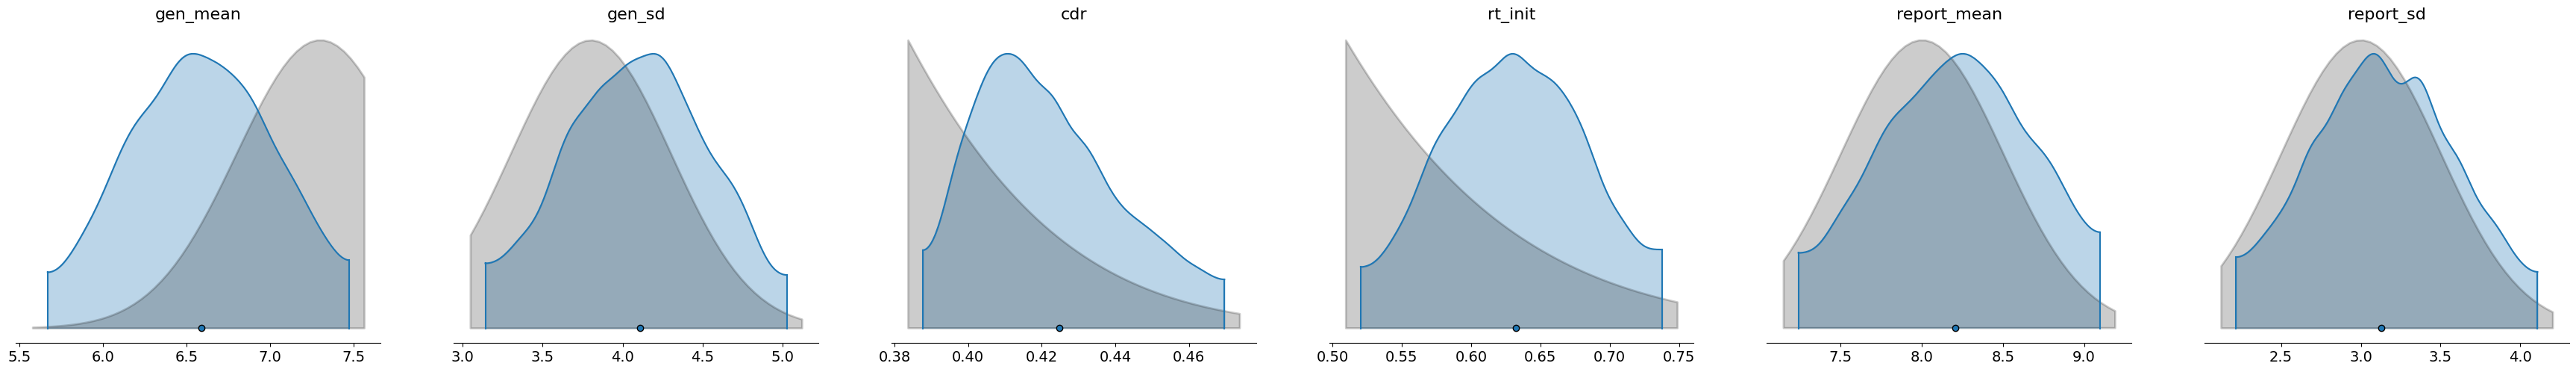

In [132]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);